In [2]:
# Missing data imputation
# File to show tables and figures
# Aneja Lab | Yale School of Medicine
# Daniel Yang, Miles Hui

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

# from sklearn import preprocessing
# from sklearn.impute import SimpleImputer
import seaborn as sns
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from tableone import TableOne


# import user written modules and constants
from constants import DATA_FOLDER, RESULT_FOLDER, DATA_NAME
from constants import VARIABLES_TYPE
import metrics
from process_data import variable_type, one_hot_encode, split_df

In [10]:
# load data
df = pd.read_stata(DATA_FOLDER + DATA_NAME) # note this dataset has survival columns
df = df.astype(float) # convert all to float
# x is a tuple where x[0]=categorical; x[1]=ordinal; x[2]=continuous
# x[0]+x[1] is treated as categorical in paper
variables = pd.read_csv(VARIABLES_TYPE, header=0)
x = variable_type(df, variables)

methods = ['sub', 'knn', 'softimpute', 'iterativesvd', 'missforest', 'midas']
### Table of overall imputaton performance ###
table1 = pd.DataFrame({'method':methods})

In [11]:
# read in the pkl data files and generate table 1
for percent_miss in [10, 20, 30, 40, 50]:
# read the dataframes corresponding to each percent missing
    df_miss = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_miss.pkl')
    df_sub = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_sub.pkl')
    df_knn = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_knn.pkl')
    # df_mice = pd.read_pickle(FOLDER + str(percent_miss) + '_df_mice.pkl')
    df_softimpute = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_softimpute.pkl')
    df_iterativesvd = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_iterativesvd.pkl')
    df_missforest = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_missforest.pkl')
    df_midas = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_midas.pkl')
    # store in table1
    table1.loc[table1['method']=='sub', str(percent_miss)+'_pfc'] = metrics.pfc(df, df_miss, df_sub, x)
    table1.loc[table1['method']=='sub', str(percent_miss)+'_rmse'] = metrics.rmse(df, df_miss, df_sub, x)
    table1.loc[table1['method']=='knn', str(percent_miss)+'_pfc'] = metrics.pfc(df, df_miss, df_knn, x)
    table1.loc[table1['method']=='knn', str(percent_miss)+'_rmse'] = metrics.rmse(df, df_miss, df_knn, x)
    # table1.loc[table1['method']=='mice', str(percent_miss) + '_pfc'] = metrics.pfc(df, df_miss, df_mice, x)
    # table1.loc[table1['method']=='mice', str(percent_miss) + '_rmse'] = metrics.rmse(df, df_miss, df_mice, x)
    table1.loc[table1['method']=='softimpute', str(percent_miss)+'_pfc'] = metrics.pfc(df, df_miss, df_softimpute, x)
    table1.loc[table1['method']=='softimpute', str(percent_miss)+'_rmse'] = metrics.rmse(df, df_miss, df_softimpute, x)
    table1.loc[table1['method']=='iterativesvd', str(percent_miss)+'_pfc'] = metrics.pfc(df, df_miss, df_iterativesvd, x)
    table1.loc[table1['method']=='iterativesvd', str(percent_miss)+'_rmse'] = metrics.rmse(df, df_miss, df_iterativesvd, x)
    table1.loc[table1['method']=='missforest', str(percent_miss)+'_pfc'] = metrics.pfc(df, df_miss, df_missforest, x)
    table1.loc[table1['method']=='missforest', str(percent_miss)+'_rmse'] = metrics.rmse(df, df_miss, df_missforest, x)
    table1.loc[table1['method']=='midas', str(percent_miss)+'_pfc'] = metrics.pfc(df, df_miss, df_midas, x)
    table1.loc[table1['method']=='midas', str(percent_miss)+'_rmse'] = metrics.rmse(df, df_miss, df_midas, x)

table1.to_csv(RESULT_FOLDER+'table1.csv', index=False)
print(table1)

         method    10_pfc   10_rmse    20_pfc   20_rmse    30_pfc   30_rmse  \
0           sub  0.406314  0.090739  0.406156  0.090234  0.406134  0.090768   
1           knn  0.310940  0.077285  0.327000  0.080125  0.346949  0.083048   
2    softimpute  0.291238  0.071147  0.298320  0.072453  0.306119  0.074784   
3  iterativesvd  0.333110  0.075419  0.339516  0.076542  0.346101  0.078325   
4    missforest  0.250942  0.071136  0.264389  0.073418  0.278126  0.077051   
5         midas  0.335276  0.079710  0.339037  0.080008  0.357253  0.081610   

     40_pfc   40_rmse    50_pfc   50_rmse  
0  0.406360  0.090855  0.406820  0.090815  
1  0.366066  0.085561  0.381710  0.087876  
2  0.314163  0.077004  0.322691  0.079517  
3  0.355887  0.079734  0.372806  0.081466  
4  0.294914  0.081217  0.310631  0.086830  
5  0.361702  0.082390  0.369739  0.082601  


In [6]:
# tablechar = TableOne(df, categorical= x[0] + x[1])
# tablechar.to_csv(RESULT_FOLDER+'tablechar.csv')
# print(tablechar)

In [36]:
### Table of performance by variables ###
table2 = pd.DataFrame({'method':methods})

percent_miss = 20
df_miss = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_miss.pkl')
df_sub = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_sub.pkl')
# df_mice = pd.read_pickle(FOLDER+str(percent_miss)+'_df_mice.pkl')
df_knn = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_knn.pkl')
df_softimpute = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_softimpute.pkl')
df_iterativesvd = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_iterativesvd.pkl')
df_missforest = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_missforest.pkl')
df_midas = pd.read_pickle(RESULT_FOLDER+str(percent_miss)+'_df_midas.pkl')



# outcome variables were not imputed
variables = pd.read_csv(VARIABLES_TYPE, header=0)
x = variable_type(df, variables)
x[0].remove('PUF_VITAL_STATUS')
x[2].remove('DX_LASTCONTACT_DEATH_MONTHS')

for var in x[2]:
    table2.loc[table2['method']=='sub', var] = metrics.rmse(df, df_miss, df_sub, x, [var])
    table2.loc[table2['method']=='knn', var] = metrics.rmse(df, df_miss, df_knn, x, [var])
    # table2.loc[table2['method']=='mice', var] = metrics.rmse(df, df_miss, df_mice, x, [var])
    table2.loc[table2['method']=='softimpute', var] = metrics.rmse(df, df_miss, df_softimpute, x, [var])
    table2.loc[table2['method']=='iterativesvd', var] = metrics.rmse(df, df_miss, df_iterativesvd, x, [var])
    table2.loc[table2['method']=='missforest', var] = metrics.rmse(df, df_miss, df_missforest, x, [var])
    table2.loc[table2['method']=='midas', var] = metrics.rmse(df, df_miss, df_midas, x, [var])
for var in x[0]+x[1]:
    table2.loc[table2['method']=='sub', var] = metrics.pfc(df, df_miss, df_sub, x, [var])
    table2.loc[table2['method']=='knn', var] = metrics.pfc(df, df_miss, df_knn, x, [var])
    # table2.loc[table2['method']=='mice', var] = metrics.pfc(df, df_miss, df_mice, x, [var])
    table2.loc[table2['method']=='softimpute', var] = metrics.pfc(df, df_miss, df_softimpute, x, [var])
    table2.loc[table2['method']=='iterativesvd', var] = metrics.pfc(df, df_miss, df_iterativesvd, x, [var])
    table2.loc[table2['method']=='missforest', var] = metrics.pfc(df, df_miss, df_missforest, x, [var])
    table2.loc[table2['method']=='midas', var] = metrics.pfc(df, df_miss, df_midas, x, [var])

# change format of table2
table2 = table2.T
new_header = table2.iloc[0]
table2 = table2[1:]
table2.columns = new_header

# calculate average percent change from substitution
table2['average_change'] = (table2['sub'] - table2[['knn', 'softimpute', 'iterativesvd', 'missforest', 'midas']].mean(axis=1))/table2['sub']*100
table2['min'] = (table2['sub'] - table2[['knn', 'softimpute', 'iterativesvd', 'missforest', 'midas']].min(axis=1))/table2['sub']*100
table2['max'] = (table2['sub'] - table2[['knn', 'softimpute', 'iterativesvd', 'missforest', 'midas']].max(axis=1))/table2['sub']*100

def com_col(x):
    return str(np.round(x['average_change'], 2)) + '% (' + str(np.round(x['max'], 1)) + '-' +  str(np.round(x['min'], 1)) + ')'

table2['Average change (range)'] = table2.apply(lambda x: com_col(x), axis=1)
table2 = table2.drop(columns= ['average_change', 'min', 'max'])
table2[['sub', 'knn', 'softimpute', 'iterativesvd', 'missforest', 'midas']].round(decimals = 3)
table2.to_csv(RESULT_FOLDER+'table2.csv')
print(table2)

method                         sub       knn softimpute iterativesvd  \
AGE                       0.140877  0.132725   0.120792     0.128089   
CROWFLY                   0.030677  0.033962   0.030161     0.030212   
TUMOR_SIZE                 0.04069  0.037739   0.035392     0.036832   
REGIONAL_NODES_EXAMINED   0.100628   0.07407   0.065154     0.068982   
SEX                       0.504922  0.474897   0.428431     0.474306   
INSURANCE_STATUS          0.349084  0.365918   0.343572     0.472337   
RX_SUMM_RADIATION         0.357157  0.235086   0.236365     0.267868   
RX_SUMM_SURGRAD_SEQ        0.06015  0.047352   0.058476      0.06015   
RX_SUMM_CHEMO             0.544792  0.363162   0.323784     0.353022   
RX_SUMM_SYSTEMIC_SUR_SEQ  0.145895  0.085647    0.10317     0.089781   
RACE                       0.12847  0.136346    0.12847      0.12847   
RX_SUMM_SURG_PRIM_SITE    0.505513  0.237645   0.204666      0.24621   
CDCC_TOTAL_BEST           0.463083  0.513979   0.463083     0.54

In [39]:
# functioon to load and process data for CPH
def load_cph(method):
    """
    Description:
        Function to load and process data for CPH
    Param:
        method = method name to load dataset
    Return:
        Returns two data frames for training and testing
    """
    if method == 'complete':
        df = pd.read_stata(DATA_FOLDER + DATA_NAME)
    else:
        df = pd.read_pickle(RESULT_FOLDER+ '/20_df_{}.pkl'.format(method))

    # preprocess dataset
    df = df.rename(columns={"DX_LASTCONTACT_DEATH_MONTHS": "Time", "PUF_VITAL_STATUS": "Event"})
    df.Event = 1 - df.Event
    df = df.astype('float32')  # convert all to float

    # x is a tuple where x[0]=categorical; x[1]=ordinal; x[2]=continuous
    # x[0]+x[1] is treated as categorical in paper
    x = variable_type(df, variables)

    # one-hot-encode df
    encoded = one_hot_encode(df, x)
    df = encoded[0]
    
    # specific the baseline categories or categories with <5 observations
    base_columns = ['SEX_1.0', 'INSURANCE_STATUS_0.0', 'RX_SUMM_RADIATION_0.0', 'RX_SUMM_SURGRAD_SEQ_0.0',
    'RX_SUMM_CHEMO_0.0', 'RX_SUMM_SYSTEMIC_SUR_SEQ_0.0', 'RACE_1.0', 'RX_SUMM_SURG_PRIM_SITE_0.0',
    'CDCC_TOTAL_BEST_0.0', 'GRADE_1.0', 'ANALYTIC_STAGE_GROUP_1.0', 'MED_INC_QUAR_16_1.0',
    'TNM_CLIN_T_3.0', 'TNM_CLIN_N_2.0', 'TNM_CLIN_M_2.0']
    few_columns = ['ANALYTIC_STAGE_GROUP_5.0', 'RX_SUMM_SURGRAD_SEQ_6.0','RX_SUMM_RADIATION_3.0',
                  'RX_SUMM_SYSTEMIC_SUR_SEQ_5.0', 'RX_SUMM_SYSTEMIC_SUR_SEQ_6.0']
    
    # drop baseline categories and categories with <=5 observations
    df  = df.drop(columns=base_columns, axis=1)
    df  = df.drop(columns=few_columns, axis=1)
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=50)

    return df_train, df_test


def CPH(df_train, df_test):
    """
    Description:
        Function to calculate c-index and get coefficient of CPH model
    Param:
        df_train = training dataset
        df_test = testing dataset
    Return:
        Returns score: c-index, coef: coefficient for CPH
    """
    # tried changing the l1_ratio around with little change
    cph = CoxPHSurvivalAnalysis(alpha=0.001)
    # cph = CoxnetSurvivalAnalysis()
    x_train, x_test, y_train, y_test = split_df(df_train, df_test)
    x_train = x_train.to_numpy().astype('float64')
    y_train = y_train.to_records(index=False)
    cph.fit(x_train, y_train)

    x_test = x_test.to_numpy().astype('float64')
    y_test = y_test.to_records(index=False)
    ci_cox = concordance_index_censored(y_test['Event'], y_test['Time'], cph.predict(x_test))
    score = np.round(ci_cox[0],3)
    coef = np.array(cph.coef_)
    print('c-index is {}'.format(score))
    return score, coef


In [41]:
# generate table 3
methods = ['complete', 'sub', 'knn', 'softimpute', 'iterativesvd', 'missforest', 'midas']
table3 = pd.DataFrame({'method': methods})
cph_coef = pd.DataFrame()
for method in methods:
    print(method)
    df_train, df_test = load_cph(method)
    score, coef = CPH(df_train, df_test)
    table3.loc[table3['method'] == method, 'C-Index'] = score
    cph_coef[method] = coef
for method in methods:
    table3.loc[table3['method'] == method, 'MAE'] = np.round(mae(cph_coef['complete'], cph_coef[method]),3)
    table3.loc[table3['method'] == method, 'MSE'] = np.round(mse(cph_coef['complete'], cph_coef[method]),3)

table3 = table3[['method', 'MAE', 'MSE', 'C-Index']]
table3 = table3.rename(columns = {'method': 'Method'})
table3['Method'] = ['Complete data', 'Substitution', 'KNN', 'SoftImpute',
                    'IterativeSVD', 'MissForest', 'Autoencoder']

table3.to_csv(RESULT_FOLDER+'table3.csv', index=False)
print(table3)

complete
c-index is 0.795
sub
c-index is 0.772
knn
c-index is 0.801
softimpute
c-index is 0.797
iterativesvd
c-index is 0.787
missforest
c-index is 0.798
midas
c-index is 0.794
          Method    MAE    MSE  C-Index
0  Complete data  0.000  0.000    0.795
1   Substitution  0.161  0.060    0.772
2            KNN  0.070  0.018    0.801
3     SoftImpute  0.070  0.013    0.797
4   IterativeSVD  0.099  0.023    0.787
5     MissForest  0.058  0.011    0.798
6    Autoencoder  0.080  0.016    0.794


In [42]:
# coefficients of the cox model
# cph_coef

In [43]:
# show the hazard ratio for non-baseline variables
df_col, _ = load_cph('complete')
df_col = df_col.drop(columns=['Time', 'Event'], axis=1)
hr = np.exp(cph_coef).set_index(df_col.columns)
hr.to_csv(RESULT_FOLDER+'cph_hr.csv')
print(hr)

                              complete       sub       knn  softimpute  \
AGE                           1.011223  1.015529  1.015116    1.015610   
CROWFLY                       0.999733  0.999706  0.999630    0.999613   
TUMOR_SIZE                    1.001942  1.002266  1.002055    1.001902   
REGIONAL_NODES_EXAMINED       0.992085  0.972587  0.987259    0.988223   
SEX_2.0                       0.806280  0.820244  0.796084    0.684916   
INSURANCE_STATUS_1.0          0.890116  0.875267  0.892037    0.966740   
INSURANCE_STATUS_2.0          1.050787  1.060301  1.068234    1.117579   
INSURANCE_STATUS_3.0          1.005752  1.004476  1.014998    1.045247   
INSURANCE_STATUS_4.0          1.045211  1.087173  1.099018    1.075627   
RX_SUMM_RADIATION_1.0         0.836864  0.977950  0.879469    0.857516   
RX_SUMM_RADIATION_2.0         0.710538  1.000475  1.014437    0.978147   
RX_SUMM_RADIATION_4.0         1.168239  1.181842  1.178363    1.048985   
RX_SUMM_RADIATION_5.0         0.900955

Long form data: 
           method     value  percent metric
0            sub  0.406314       10    pfc
1            knn  0.310940       10    pfc
2     softimpute  0.291238       10    pfc
3   iterativesvd  0.333110       10    pfc
4     missforest  0.250942       10    pfc
5          midas  0.335276       10    pfc
6            sub  0.090739       10   rmse
7            knn  0.077285       10   rmse
8     softimpute  0.071147       10   rmse
9   iterativesvd  0.075419       10   rmse
10    missforest  0.071136       10   rmse
11         midas  0.079710       10   rmse
12           sub  0.406156       20    pfc
13           knn  0.327000       20    pfc
14    softimpute  0.298320       20    pfc
15  iterativesvd  0.339516       20    pfc
16    missforest  0.264389       20    pfc
17         midas  0.339037       20    pfc
18           sub  0.090234       20   rmse
19           knn  0.080125       20   rmse
20    softimpute  0.072453       20   rmse
21  iterativesvd  0.076542       20 

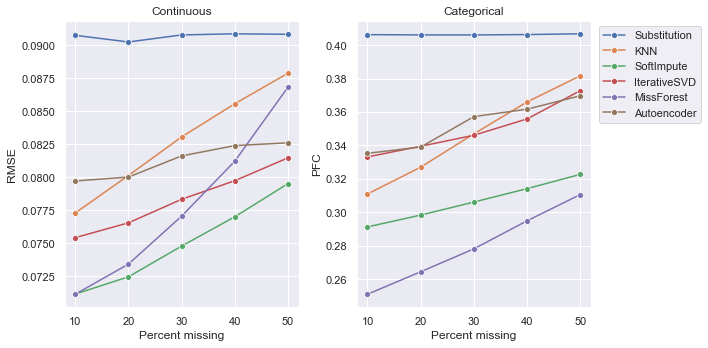

In [46]:
# Figure 2
# load data and convert to long form
df = pd.read_csv(RESULT_FOLDER+'table1.csv')
df = pd.melt(df, id_vars='method')
df[['percent', 'metric']] = df.variable.str.split('_', expand=True)
df['percent'] = pd.to_numeric(df['percent'])
df.drop(columns=['variable'], inplace = True)
print('Long form data: \n', df)

# split rmse and pfc into 2 separate dataframes for graphing
df_rmse = df[df['metric']=='rmse']
df_pfc = df[df['metric']=='pfc']
sns.set_theme(style='darkgrid')

# combined rmse and pfc lineplot
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.lineplot(x='percent', y='value', data=df_rmse, marker = 'o', hue='method', ax=ax[0], legend=False)
ax[0].set_xticks([10, 20, 30, 40, 50])
ax[0].set_xlabel('Percent missing')
ax[0].set_ylabel('RMSE')
ax[0].set_title('Continuous')
sns.lineplot(x='percent', y='value', data=df_pfc, marker = 'o', hue='method', ax=ax[1])
ax[1].set_xticks([10, 20, 30, 40, 50])
ax[1].set_xlabel('Percent missing')
ax[1].set_ylabel('PFC')
ax[1].set_title('Categorical')
ax[1].legend(bbox_to_anchor=(1.01, 1), labels = ['Substitution', 'KNN', 'SoftImpute', 'IterativeSVD', 'MissForest', 'Autoencoder'])
fig.tight_layout()
plt.savefig(RESULT_FOLDER+'figure2.png', dpi=300, bbox_inches='tight')
plt.show()

Long form data: 
           method variable        value  runtime_row
0            sub       10     0.082088     0.000002
1            knn       10  1148.382783     0.022610
2     softimpute       10    11.382767     0.000224
3   iterativesvd       10    12.863560     0.000253
4     missforest       10   112.037509     0.002206
5          midas       10   915.137591     0.018018
6            sub       20     0.078009     0.000002
7            knn       20  1612.867655     0.031756
8     softimpute       20    13.405374     0.000264
9   iterativesvd       20    13.372037     0.000263
10    missforest       20   144.150477     0.002838
11         midas       20   921.869278     0.018151
12           sub       30     0.077576     0.000002
13           knn       30  1852.870640     0.036481
14    softimpute       30    16.361337     0.000322
15  iterativesvd       30    15.718438     0.000309
16    missforest       30   186.821734     0.003678
17         midas       30   911.045513     0.0

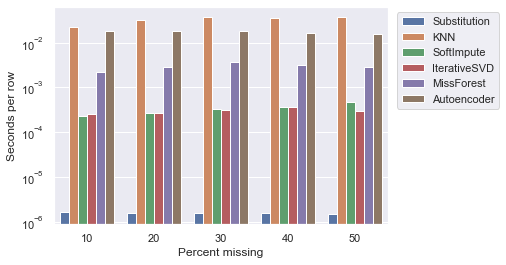

In [49]:
# Figure 3
### Runtimes ###

df = pd.read_csv(RESULT_FOLDER+'runtimes.csv')
df = pd.melt(df, id_vars='method')
df['runtime_row'] = df['value']/50790 # normalize runtime by row count
print('Long form data: \n', df)

fig = sns.barplot(x='variable', y='runtime_row', data=df, hue='method')
plt.xlabel('Percent missing')
plt.ylabel('Seconds per row')
plt.yscale('log')
h, l = fig.get_legend_handles_labels()
labels = ['Substitution','KNN', 'SoftImpute', 'IterativeSVD', 'MissForest', 'Autoencoder']
plt.legend(bbox_to_anchor=(1.01, 1), handles = h, labels = labels)
plt.savefig(RESULT_FOLDER+'runtime.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
# print average runtimes
print('Substiution:\n', df[df['method']=='sub'].mean())
print('KNN:\n', df[df['method']=='knn'].mean())
print('SoftImpute:\n', df[df['method']=='softimpute'].mean())
print('IterativeSVD:\n', df[df['method']=='iterativesvd'].mean())
print('MissForest:\n', df[df['method']=='missforest'].mean())
print('Autoencoder:\n', df[df['method']=='midas'].mean())

Substiution:
 variable       2.040608e+08
value          7.802434e-02
runtime_row    1.536215e-06
dtype: float64
KNN:
 variable       2.040608e+08
value          1.673968e+03
runtime_row    3.295861e-02
dtype: float64
SoftImpute:
 variable       2.040608e+08
value          1.664228e+01
runtime_row    3.276685e-04
dtype: float64
IterativeSVD:
 variable       2.040608e+08
value          1.507101e+01
runtime_row    2.967319e-04
dtype: float64
MissForest:
 variable       2.040608e+08
value          1.504580e+02
runtime_row    2.962354e-03
dtype: float64
Autoencoder:
 variable       2.040608e+08
value          8.757627e+02
runtime_row    1.724282e-02
dtype: float64
